In [1]:
import logging
import multiprocessing as mp
import os
import random as rn
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import Normalizer
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    rn.seed(seed)

Index(['timeStamp', 'demand', 'precip', 'temp'], dtype='object')
(1000, 4) 0


,demand,precip,temp
timeStamp,,,
2012-01-01 00:00:00,4937.5,0.0000,46.13
2012-01-01 01:00:00,4752.1,0.0000,45.89
2012-01-01 02:00:00,4542.6,0.0000,45.04
2012-01-01 03:00:00,4357.7,0.0000,45.03
2012-01-01 04:00:00,4275.5,0.0000,42.61
2012-01-01 05:00:00,4274.7,0.0000,39.02
2012-01-01 06:00:00,4324.9,0.0000,38.78
2012-01-01 07:00:00,4350.0,0.0000,42.74
2012-01-01 08:00:00,4480.9,0.0000,38.90


(1000, 1) 0


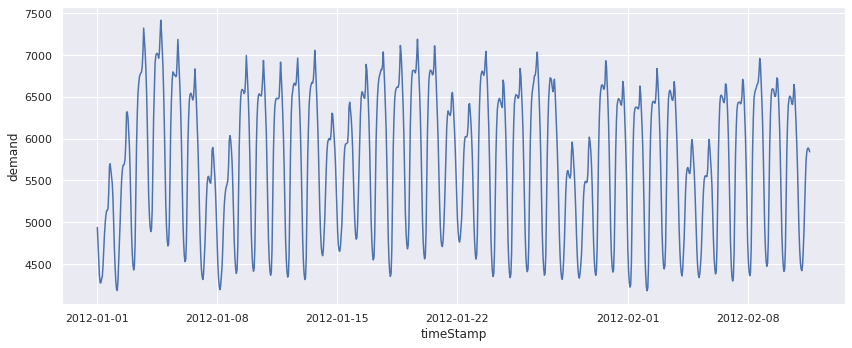

In [2]:
# data = pd.read_csv("AirPassengers.csv")
data = pd.read_csv("data/nyc_energy.csv")[:-81][:1000]
# data = pd.read_csv("data/nyc_taxi.csv").reset_index(drop=True)[:2000]
# data = yf.download("GOOG").reset_index()[-4000:]
# data = pd.read_csv("data/temperature.csv")[1:-792]

print(data.columns)

# target = "#Passengers"
dt, target = "timeStamp", "demand"
# dt, target = "timestamp", "value"
# dt, target = "Date", "Adj Close"
# dt, target = "datetime", "Tel Aviv District"
print(data.shape, data[target].isna().sum())

data[dt] = pd.to_datetime(data[dt])
data = data.set_index(dt)
display(data)
data = data[[target]]
data = data.resample("h").mean().interpolate()
print(data.shape, data[target].isna().sum())

plt.figure(figsize=(12, 5))
sns.lineplot(x=data.index, y=target, data=data)
plt.tight_layout()
plt.show()

In [3]:
x_train, x_test, y_train, y_test = train_test_split(data.index.values, data[target].values,
                                                    shuffle=False, test_size=.2)
# x_train = x_train.reshape(-1, 1)
# x_test = x_test.reshape(-1, 1)

# y_train_mean = np.mean(y_train)
# y_train_std = np.std(y_train)
# y_train = (y_train - y_train_mean) / y_train_std
# y_test = (y_test - y_train_mean) / y_train_std

df_train = pd.DataFrame({dt: x_train, target: y_train})
df_test = pd.DataFrame({dt: x_test, target: y_test})
display(df_train, df_test)

,timeStamp,demand
0,2012-01-01 00:00:00,4937.5
1,2012-01-01 01:00:00,4752.1
2,2012-01-01 02:00:00,4542.6
3,2012-01-01 03:00:00,4357.7
4,2012-01-01 04:00:00,4275.5
5,2012-01-01 05:00:00,4274.7
6,2012-01-01 06:00:00,4324.9
7,2012-01-01 07:00:00,4350.0
8,2012-01-01 08:00:00,4480.9
9,2012-01-01 09:00:00,4664.2


,timeStamp,demand
0,2012-02-03 08:00:00,6246.6
1,2012-02-03 09:00:00,6475.8
2,2012-02-03 10:00:00,6556.2
3,2012-02-03 11:00:00,6578.9
4,2012-02-03 12:00:00,6558.8
5,2012-02-03 13:00:00,6514.1
6,2012-02-03 14:00:00,6464.2
7,2012-02-03 15:00:00,6459.0
8,2012-02-03 16:00:00,6516.1
9,2012-02-03 17:00:00,6681.8


In [4]:
time_series_settings = {
    "time_column_name": dt,
    "max_horizon": "auto",
    "target_lags": "auto",
    "target_rolling_window_size": "auto",
    "featurization": "auto"
}
automl_config = AutoMLConfig(task="forecasting", training_data=df_train, label_column_name=target,
                             max_cores_per_iteration=-1, enable_early_stopping=True,
                             n_cross_validations=5, verbosity=logging.INFO, **time_series_settings)
ws = Workspace.from_config()
experiment = Experiment(ws, "experiment")

In [5]:
reset_seed()

best_run, fitted_model = experiment.submit(automl_config, show_output=True).get_output()
print(fitted_model.steps)

Running on local machine
Parent Run ID: AutoML_af59302c-c965-47dc-a6c1-3477150ffe67

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Heuristic parameters: Target_Lag = '[1, 2]', Target_Rolling_Window = '3', Max_Horizon = '24'.


/projappl/project_2003107/anaconda3/envs/azure_automl/lib/python3.6/site-packages/azureml/_restclient/workspace_client.py:380: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self._logger.warn('Converting non-string tag to string: (%s: %s)', key, val)
WARNING - Converting non-string tag to string: (forecasting_target_lags: [1, 2])
WARNING - Converting non-string tag to string: (forecasting_target_rolling_window_size: 3)
WARNING - Converting non-string tag to string: (forecasting_max_horizon: 24)


Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.


/projappl/project_2003107/anaconda3/envs/azure_automl/lib/python3.6/site-packages/azureml/automl/runtime/featurizer/transformer/timeseries/rolling_window.py:260: UserWarning: RollingWindow: "center" is not a configurable window option.
  'a configurable window option.')
/projappl/project_2003107/anaconda3/envs/azure_automl/lib/python3.6/site-packages/azureml/automl/runtime/featurizer/transformer/timeseries/rolling_window.py:260: UserWarning: RollingWindow: "closed" is not a configurable window option.
  'a configurable window option.')


Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
            

WARNING - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))': /azureml/ExperimentRun/dcid.AutoML_af59302c-c965-47dc-a6c1-3477150ffe67_27/outputs/env_dependencies.json?sv=2019-02-02&sr=b&sig=Sk%2FHhxLHxHeF%2FeUr%2BYKGKcs2mIRH%2BPPekKfcfbaW3pg%3D&st=2020-08-19T04%3A49%3A41Z&se=2020-08-20T04%3A59%3A41Z&sp=rcw&comp=block&blockid=TURBd01EQXdNREF3TURBd01EQXdNREF3TURBd01EQXdNREF3TURBd01EQSUzRA%3D%3D&timeout=30
WARNING - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))': /azureml/ExperimentRun/dcid.AutoML_af59302c-c965-47dc-a6c1-3477150ffe67_27/outputs/scoring_file_v_1_0_0.py?sv=2019-02-02&sr=b&sig=rliB3dPZ%2FP%2BHcEHY8gEniadI6%2BdX%2Fr3yauhBoOnx0%2BQ%3D&st=2020-08-19T04%3A49%3A41Z&se=2020-08-20T04%3

RobustScaler DecisionTree                      0:03:00       0.0447    0.0330
        28   MinMaxScaler RandomForest                      0:00:20       0.0531    0.0330
        29   MinMaxScaler DecisionTree                      0:00:19       0.0730    0.0330
        30   SparseNormalizer ExtremeRandomTrees            0:00:41       0.1139    0.0330
        31   StandardScalerWrapper LightGBM                 0:00:20       0.0738    0.0330
        32   

/projappl/project_2003107/anaconda3/envs/azure_automl/lib/python3.6/site-packages/azureml/automl/runtime/shared/model_wrappers.py:755: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.model.transform(X)
/projappl/project_2003107/anaconda3/envs/azure_automl/lib/python3.6/site-packages/azureml/automl/runtime/shared/model_wrappers.py:755: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.model.transform(X)
/projappl/project_2003107/anaconda3/envs/azure_automl/lib/python3.6/site-packages/azureml/automl/runtime/shared/model_wrappers.py:755: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.model.transform(X)
/projappl/project_2003107/anaconda3/envs/azure_automl/lib/python3.6/site-packages/azureml/automl/runtime/shared/model_wrappers.py:755: DataConversionWarning: Data with i

/projappl/project_2003107/anaconda3/envs/azure_automl/lib/python3.6/site-packages/azureml/automl/runtime/shared/model_wrappers.py:755: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.model.transform(X)
/projappl/project_2003107/anaconda3/envs/azure_automl/lib/python3.6/site-packages/azureml/automl/runtime/shared/model_wrappers.py:755: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.model.transform(X)
/projappl/project_2003107/anaconda3/envs/azure_automl/lib/python3.6/site-packages/azureml/automl/runtime/shared/model_wrappers.py:755: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.model.transform(X)
/projappl/project_2003107/anaconda3/envs/azure_automl/lib/python3.6/site-packages/azureml/automl/runtime/shared/model_wrappers.py:755: DataConversionWarning: Data with i

VotingEnsemble                                 0:00:48       0.0179    0.0179
Stopping criteria reached at iteration 33. Ending experiment.
****************************************************************************************************


numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


Current status: BestRunExplainModel. Best run model explanations started
Current status: ModelExplanationDataSetSetup. Model explanations data setup completed
Current status: PickSurrogateModel. Choosing LightGBM as the surrogate model for explanations


From version 0.21, test_size will always complement train_size unless both are specified.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Current status: EngineeredFeatureExplanations. Computation of engineered features started


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Current status: EngineeredFeatureExplanations. Computation of engineered features completed
Current status: BestRunExplainModel. Best run model explanations completed
****************************************************************************************************
[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None,
           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('21', Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('extratreesregressor', ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features=0.9, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min...9, silent=True, subsample=0.9,
         subsample_for_bin=200000, subsample_freq=0, verbose=-1))]))],
               flatten_transform=None,
               weights=[0.13333333333333333, 0.13333333333333333, 0.06666666666666667, 0.

In [6]:
y_pred = fitted_model.forecast(df_test[[dt]])[0]
y_pred

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

The concatenated objects may have different ts_value_colname values, result using the ts_value_colname of the first object
Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

The concatenated objects may have different ts_value_colname values, result using the ts_value_colname of the first object
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Sortin

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


array([6141.83029169, 6428.92012093, 6480.44972792, 6486.35027896,
       6483.38089674, 6571.64878993, 6568.98065129, 6569.87531815,
       6722.91249052, 6844.01066548, 6768.74889103, 6596.30502851,
       6345.44764965, 6142.41183417, 5652.39679179, 5355.16504214,
       4865.983318  , 4640.62567667, 4460.46323221, 4444.20559981,
       4455.00241466, 4584.38177569, 4886.94690635, 5089.22030045,
       5284.29332086, 5441.16699703, 5658.98202808, 5672.10553371,
       5807.19133264, 5728.41522227, 5729.1766742 , 5732.19527318,
       5776.26363266, 5906.62860469, 5905.15612615, 5878.98664927,
       5828.41852591, 5768.5389042 , 5584.63979292, 5372.59737073,
       4855.62329292, 4628.57893312, 4448.51126204, 4430.76647893,
       4441.37362973, 4566.13506142, 4859.55682559, 5049.78377106,
       5212.44931693, 5334.79587111, 5557.48765802, 5575.57919478,
       5690.02748863, 5708.20870208, 5708.45754155, 5711.39306404,
       5793.85582224, 5898.27545723, 5902.70065432, 5880.74577

In [25]:
x_pred = pd.date_range(df_train[dt].iloc[-1], periods=len(df_test)+1,
                       freq=pd.infer_freq(df_train[dt]))[1:]
y_pred = fitted_model.forecast(pd.DataFrame({dt: x_pred}))[0]
df_pred = pd.DataFrame({dt: x_pred, target: y_pred})
df_pred

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

The concatenated objects may have different ts_value_colname values, result using the ts_value_colname of the first object
Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

The concatenated objects may have different ts_value_colname values, result using the ts_value_colname of the first object
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Sortin

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


,timeStamp,demand
0,2012-02-03 08:00:00,6141.83
1,2012-02-03 09:00:00,6428.92
2,2012-02-03 10:00:00,6480.45
3,2012-02-03 11:00:00,6486.35
4,2012-02-03 12:00:00,6483.38
5,2012-02-03 13:00:00,6571.65
6,2012-02-03 14:00:00,6568.98
7,2012-02-03 15:00:00,6569.88
8,2012-02-03 16:00:00,6722.91
9,2012-02-03 17:00:00,6844.01


RMSE: 110.6075561228045
R^2: 0.9810122161369392


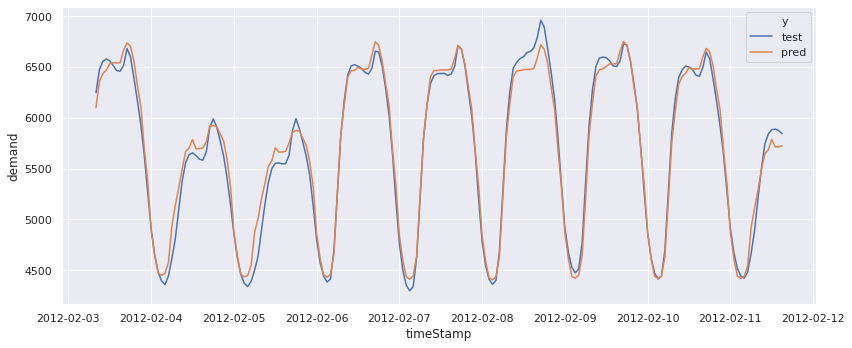

In [7]:
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R^2: {r2_score(y_test, y_pred)}")

df = pd.DataFrame({dt: df_test[dt].values, "test": y_test, "pred": y_pred})

plt.figure(figsize=(12, 5))
sns.lineplot(x=dt, y=target, hue="y", data=df.melt(dt, var_name="y", value_name=target))
plt.tight_layout()
plt.show()